# Отток клиентов оператора связи

##### В данной работе представлена модель машинного обучения, предсказывающая уйдёт клиент в ближайшее время или нет.

##### Необходимость данной работы обусловлена желанием оператора связи «Ниединогоразрыва.ком» научиться прогнозировать отток клиентов. 

##### В распоряжении имеются персональные данные о некоторых клиентах, информация об их тарифах и договорах.

##### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.
<a id='0-section'></a>
###### Данное исследование разделим на несколько частей.

##### I. Изучение общей информации:
* [1. Изучение файлов с данными, получение общей информации](#1-section)

##### II. Разведочный анализ данных:
* [1. Детальный анализ данных](#2-section)

##### III. Подготовка данных к обучению:
* [1. Подготовка признаков](#3-section)
* [2. Разбиение на выборки](#4-section)

##### IV. Исследование моделей классификации:
* [1. Константная модель](#5-section)
* [2. Дисбаланс классов](#6-section)
* [3. Баланс классов](#7-section)
* [4. Визуализация метрик](#8-section)

##### [V. Общий вывод](#9-section)

## I. Изучение общей информации

<a id='1-section'></a>
### 1. Изучение файлов с данными, получение общей информации

[Вернуться к оглавлению](#0-section)

In [1]:
# загрузим необходимые библиотеки
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    recall_score, 
    precision_score, 
    f1_score, 
    precision_recall_curve, 
    roc_auc_score, 
    roc_curve,
    make_scorer
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from datetime import datetime

In [2]:
# создадим функцию для загрузки датафрейма
def get_df(data):
    try:
        df = pd.read_csv('/datasets/final_provider/{}.csv'.format(data), index_col='customerID')
    except:
        print('Ошибка при чтении файла')
    df.columns = df.columns.str.lower()
    print('Несколько строк из датафрейма')
    print()
    display(df.sample(5))
    print()
    print('Общая информация о датафрейме')
    print()
    print(df.info())
    return df

In [3]:
# загрузим данные, содержащие информацию о договорах
contract = get_df('contract')

Несколько строк из датафрейма



,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
customerID,,,,,,,
8148-NLEGT,2016-08-01,No,Two year,No,Electronic check,22.95,1014.25
0486-LGCCH,2019-03-01,No,Two year,No,Mailed check,19.65,225.75
8285-ABVLB,2014-04-01,No,Two year,No,Credit card (automatic),19.85,1328.35
7503-ZGUZJ,2019-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Mailed check,84.65,84.65
6986-IXNDM,2018-12-01,No,Month-to-month,Yes,Electronic check,92.90,1337.45



Общая информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
begindate           7043 non-null object
enddate             7043 non-null object
type                7043 non-null object
paperlessbilling    7043 non-null object
paymentmethod       7043 non-null object
monthlycharges      7043 non-null float64
totalcharges        7043 non-null object
dtypes: float64(1), object(6)
memory usage: 440.2+ KB
None


In [4]:
# загрузим персональные данные клиентов
personal = get_df('personal')

Несколько строк из датафрейма



,gender,seniorcitizen,partner,dependents
customerID,,,,
1984-FCOWB,Female,0,Yes,No
6110-OHIHY,Male,0,No,No
8751-EDEKA,Female,0,Yes,No
6906-ANDWJ,Male,0,Yes,Yes
7797-EJMDP,Female,0,No,No



Общая информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
gender           7043 non-null object
seniorcitizen    7043 non-null int64
partner          7043 non-null object
dependents       7043 non-null object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB
None


In [5]:
# загрузим данные, содержащие информацию об интернет-услугах
internet = get_df('internet')

Несколько строк из датафрейма



,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
customerID,,,,,,,
1456-TWCGB,DSL,No,Yes,No,No,No,No
5134-IKDAY,Fiber optic,No,No,No,No,No,No
9136-ALYBR,DSL,No,No,No,No,No,No
4626-GYCZP,Fiber optic,No,No,No,No,Yes,Yes
4366-CTOUZ,Fiber optic,No,Yes,No,Yes,Yes,Yes



Общая информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
internetservice     5517 non-null object
onlinesecurity      5517 non-null object
onlinebackup        5517 non-null object
deviceprotection    5517 non-null object
techsupport         5517 non-null object
streamingtv         5517 non-null object
streamingmovies     5517 non-null object
dtypes: object(7)
memory usage: 344.8+ KB
None


In [6]:
# загрузим данные, содержащие информацию об услугах телефонии
phone = get_df('phone')

Несколько строк из датафрейма



,multiplelines
customerID,
6416-JNVRK,No
3413-CSSTH,Yes
4550-EVXNY,No
5168-MQQCA,Yes
0582-AVCLN,No



Общая информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
multiplelines    6361 non-null object
dtypes: object(1)
memory usage: 99.4+ KB
None


В наличии имеются персональные данные 7043 клиентов, столько же договоров.

Но интернет-услугами из них пользуются 5517 человек, а услугами телефонии - 6361.

Также отметим, что в данных нет очевидных пропусков.

 ## II. Разведочный анализ данных

<a id='2-section'></a>
### 1. Детальный анализ данных

[Вернуться к оглавлению](#0-section)

In [7]:
# подробнее изучим данные
# создадим функцию, возвращающую детальную информацию о данных по столбцу
def get_column_info(data, column):
    print('{: ^}'.format("_" * (len("Числовое описание данных столбца") + len(column) + 1)))
    print()
    print('Числовое описание данных столбца "{}"'.format(column))
    print()
    if data[column].isnull().sum() > 0:
        print('Количество пропусков: {}'.format(data[column].isnull().sum()))
    else:
        print('В столбце нет пропусков')
    print()
    print(data[column].describe())
    print()
    # выведем max, min, наиболее и наименее частотные значения столбца
    # если уникальных значений больше пяти
    if len(data[column].unique()) > 5:
        if data[column].value_counts().min() != data[column].value_counts().max():
            print('Наиболее частотные значения столбца')
            print()
            print(data[column].value_counts().head())
            print()
            print('Наименее частотные значения столбца')
            print()
            print(data[column].value_counts().tail())
            print()
        print()
        if data[column].dtype in ['int64', 'float64']:
            if data.groupby(column)[column].count().max() != data.groupby(column)[column].count().min():
                print('Максимальные значения столбца')
                print()
                print(data.groupby(column)[column].count()[::-1].head())
                print()
                print('Минимальные значения столбца')
                print()
                print(data.groupby(column)[column].count().head()[::-1])
                print()
            print("Диаграмма размаха столбца", column)
            sns.boxplot(x=data[column])
            plt.show()
            print()
            print("Гистограмма для столбца", column)
            ax = sns.distplot(data[column])
            plt.show()
    else:
        print()
        print('Распределение данных столбца "{}"'.format(column))
        print()
        print(data[column].value_counts())
        data[column].value_counts().plot(kind='pie', subplots=True, figsize=(9,6), autopct='%1.1f%%')
        plt.show()

In [8]:
# создадим функцию для вывода информации о всех столбцах датафрейма
def get_all_columns_info(data):
    for column in data.columns:
        get_column_info(data, column)

__________________________________________

Числовое описание данных столбца "begindate"

В столбце нет пропусков

count           7043
unique            77
top       2014-02-01
freq             366
Name: begindate, dtype: object

Наиболее частотные значения столбца

2014-02-01    366
2019-11-01    237
2019-09-01    237
2019-10-01    237
2020-01-01    233
Name: begindate, dtype: int64

Наименее частотные значения столбца

2020-02-01    11
2014-01-01     7
2013-10-01     3
2013-12-01     3
2013-11-01     2
Name: begindate, dtype: int64


________________________________________

Числовое описание данных столбца "enddate"

В столбце нет пропусков

count     7043
unique       5
top         No
freq      5174
Name: enddate, dtype: object


Распределение данных столбца "enddate"

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: enddate, dtype: int64


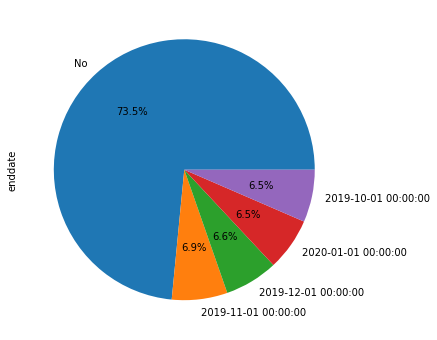

_____________________________________

Числовое описание данных столбца "type"

В столбце нет пропусков

count               7043
unique                 3
top       Month-to-month
freq                3875
Name: type, dtype: object


Распределение данных столбца "type"

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64


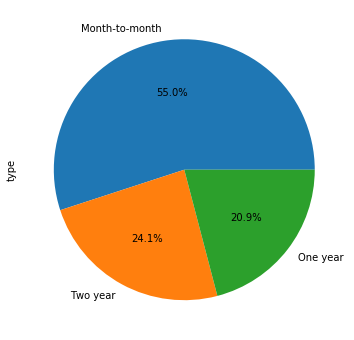

_________________________________________________

Числовое описание данных столбца "paperlessbilling"

В столбце нет пропусков

count     7043
unique       2
top        Yes
freq      4171
Name: paperlessbilling, dtype: object


Распределение данных столбца "paperlessbilling"

Yes    4171
No     2872
Name: paperlessbilling, dtype: int64


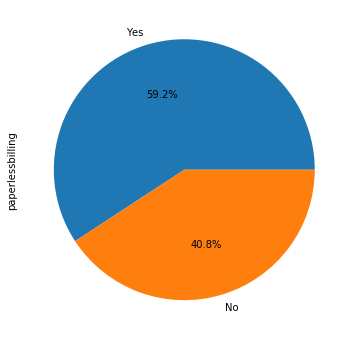

______________________________________________

Числовое описание данных столбца "paymentmethod"

В столбце нет пропусков

count                 7043
unique                   4
top       Electronic check
freq                  2365
Name: paymentmethod, dtype: object


Распределение данных столбца "paymentmethod"

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: paymentmethod, dtype: int64


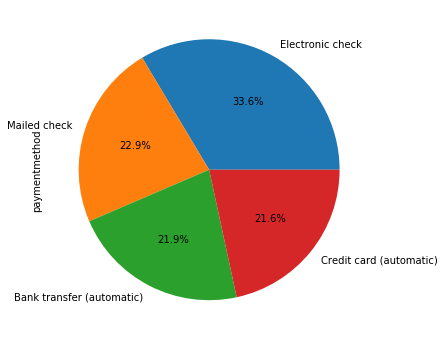

_______________________________________________

Числовое описание данных столбца "monthlycharges"

В столбце нет пропусков

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthlycharges, dtype: float64

Наиболее частотные значения столбца

20.05    61
19.85    45
19.95    44
19.90    44
20.00    43
Name: monthlycharges, dtype: int64

Наименее частотные значения столбца

114.75    1
103.60    1
113.40    1
57.65     1
113.30    1
Name: monthlycharges, dtype: int64


Максимальные значения столбца

monthlycharges
118.75    1
118.65    1
118.60    2
118.35    1
118.20    1
Name: monthlycharges, dtype: int64

Минимальные значения столбца

monthlycharges
18.75    1
18.70    2
18.55    1
18.40    1
18.25    1
Name: monthlycharges, dtype: int64

Диаграмма размаха столбца monthlycharges


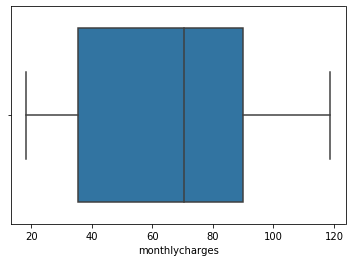


Гистограмма для столбца monthlycharges


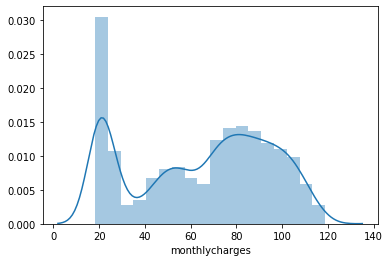

_____________________________________________

Числовое описание данных столбца "totalcharges"

В столбце нет пропусков

count     7043
unique    6531
top           
freq        11
Name: totalcharges, dtype: object

Наиболее частотные значения столбца

         11
20.2     11
19.75     9
19.65     8
20.05     8
Name: totalcharges, dtype: int64

Наименее частотные значения столбца

418.25     1
7576.7     1
779.25     1
5356.45    1
2448.75    1
Name: totalcharges, dtype: int64




In [9]:
# применим функцию get_all_columns_info к contract
get_all_columns_info(contract)

По данным о договорах можно сказать, что
- имеется 7043 договора, из них 5174 действующих;
- чуть больше половины клиентов используют ежемесячный платёж;
- значения ежемесячного платежа сильно отличаются друг от друга. Об этом говорит большое значение стандартного отклонения  `30.09`. Оно объясняется большим количеством договоров с ежемесячным платежом примерно в `20` и в `70 - 110`;
- столбец с общими расходим имеет тип данных "object", а должен быть "float". В информации по столбцу видно, что у 11 договоров пустое значение поля "totalcharges".

In [10]:
# посмотрим на пропущенные значения в столбце "totalcharges"
contract.query('totalcharges in " "')

,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,


Заметим, что пропуски получились из-за того, что договоры были заключены в этом месяце, поэтому информации об общих расходах пока нет.

In [11]:
# получим информацию об общих расходах, заполнив пропуски
for i in contract.index:
    if i in contract.query('totalcharges in " "').index:
        contract.loc[i,'totalcharges'] = contract.loc[i,'monthlycharges']

_____________________________________________

Числовое описание данных столбца "totalcharges"

В столбце нет пропусков

count    7043.000000
mean     2279.798992
std      2266.730170
min        18.800000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: totalcharges, dtype: float64

Наиболее частотные значения столбца

20.20    11
19.75     9
19.65     8
20.05     8
19.90     8
Name: totalcharges, dtype: int64

Наименее частотные значения столбца

1534.05    1
1066.15    1
999.80     1
8333.95    1
1024.00    1
Name: totalcharges, dtype: int64


Максимальные значения столбца

totalcharges
8684.80    1
8672.45    1
8670.10    1
8594.40    1
8564.75    1
Name: totalcharges, dtype: int64

Минимальные значения столбца

totalcharges
19.05    1
19.00    1
18.90    1
18.85    2
18.80    1
Name: totalcharges, dtype: int64

Диаграмма размаха столбца totalcharges


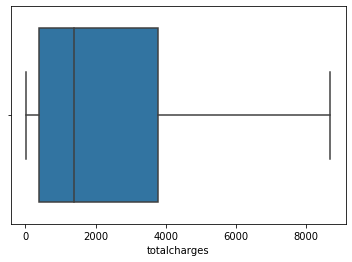


Гистограмма для столбца totalcharges


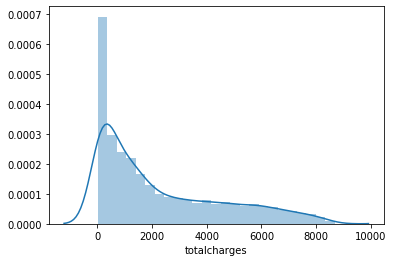

In [12]:
# изменим тип данных столбца "totalcharges" на вещественный и посмотрим информацию об этом столдце
contract['totalcharges'] = contract['totalcharges'].astype('float64')
get_column_info(contract, 'totalcharges')

График сильно скошен вправо. Причина этому - клиенты, которые уже несколько лет пользуются услугами компании и соответственно, их общие расходы намного больше расходов недавних клиентов. 

_______________________________________

Числовое описание данных столбца "gender"

В столбце нет пропусков

count     7043
unique       2
top       Male
freq      3555
Name: gender, dtype: object


Распределение данных столбца "gender"

Male      3555
Female    3488
Name: gender, dtype: int64


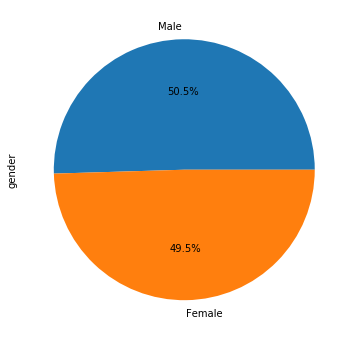

______________________________________________

Числовое описание данных столбца "seniorcitizen"

В столбце нет пропусков

count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: seniorcitizen, dtype: float64


Распределение данных столбца "seniorcitizen"

0    5901
1    1142
Name: seniorcitizen, dtype: int64


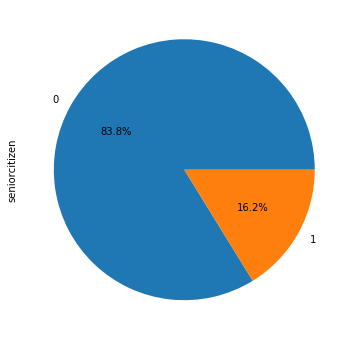

________________________________________

Числовое описание данных столбца "partner"

В столбце нет пропусков

count     7043
unique       2
top         No
freq      3641
Name: partner, dtype: object


Распределение данных столбца "partner"

No     3641
Yes    3402
Name: partner, dtype: int64


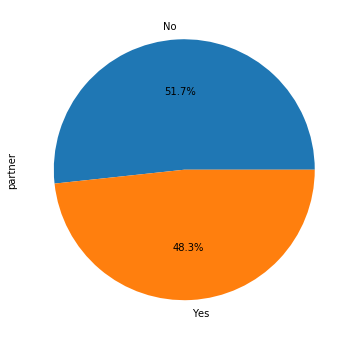

___________________________________________

Числовое описание данных столбца "dependents"

В столбце нет пропусков

count     7043
unique       2
top         No
freq      4933
Name: dependents, dtype: object


Распределение данных столбца "dependents"

No     4933
Yes    2110
Name: dependents, dtype: int64


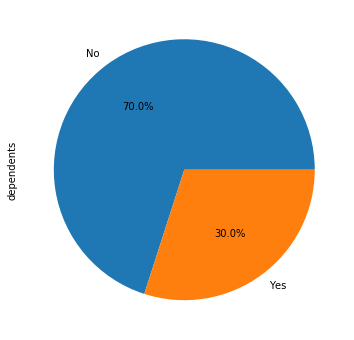

In [13]:
# применим функцию get_all_columns_info к personal
get_all_columns_info(personal)

По персональным данным клиентов можно сказать о том, что
- среди клиентов примерно одинаковое количество мужчин и женщин;
- имеется `16.2%` пенсионеров и `30%` иждивенцев.

________________________________________________

Числовое описание данных столбца "internetservice"

В столбце нет пропусков

count            5517
unique              2
top       Fiber optic
freq             3096
Name: internetservice, dtype: object


Распределение данных столбца "internetservice"

Fiber optic    3096
DSL            2421
Name: internetservice, dtype: int64


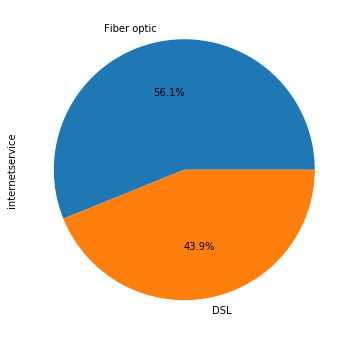

_______________________________________________

Числовое описание данных столбца "onlinesecurity"

В столбце нет пропусков

count     5517
unique       2
top         No
freq      3498
Name: onlinesecurity, dtype: object


Распределение данных столбца "onlinesecurity"

No     3498
Yes    2019
Name: onlinesecurity, dtype: int64


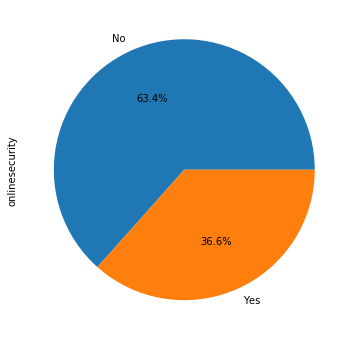

_____________________________________________

Числовое описание данных столбца "onlinebackup"

В столбце нет пропусков

count     5517
unique       2
top         No
freq      3088
Name: onlinebackup, dtype: object


Распределение данных столбца "onlinebackup"

No     3088
Yes    2429
Name: onlinebackup, dtype: int64


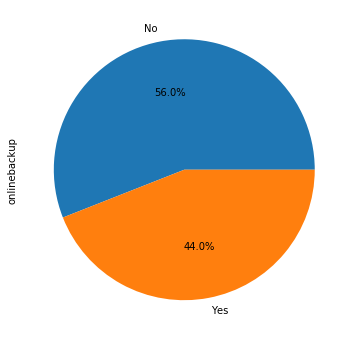

_________________________________________________

Числовое описание данных столбца "deviceprotection"

В столбце нет пропусков

count     5517
unique       2
top         No
freq      3095
Name: deviceprotection, dtype: object


Распределение данных столбца "deviceprotection"

No     3095
Yes    2422
Name: deviceprotection, dtype: int64


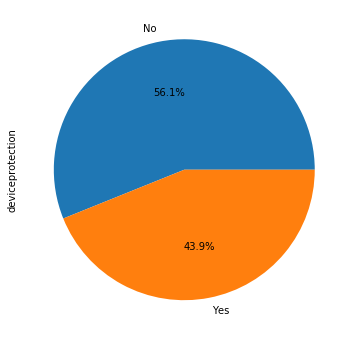

____________________________________________

Числовое описание данных столбца "techsupport"

В столбце нет пропусков

count     5517
unique       2
top         No
freq      3473
Name: techsupport, dtype: object


Распределение данных столбца "techsupport"

No     3473
Yes    2044
Name: techsupport, dtype: int64


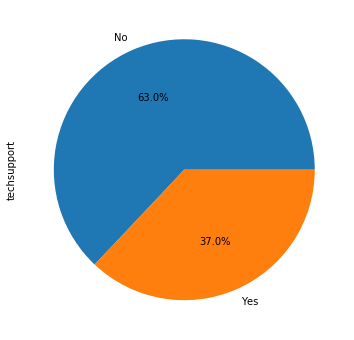

____________________________________________

Числовое описание данных столбца "streamingtv"

В столбце нет пропусков

count     5517
unique       2
top         No
freq      2810
Name: streamingtv, dtype: object


Распределение данных столбца "streamingtv"

No     2810
Yes    2707
Name: streamingtv, dtype: int64


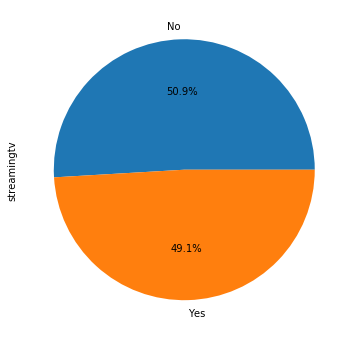

________________________________________________

Числовое описание данных столбца "streamingmovies"

В столбце нет пропусков

count     5517
unique       2
top         No
freq      2785
Name: streamingmovies, dtype: object


Распределение данных столбца "streamingmovies"

No     2785
Yes    2732
Name: streamingmovies, dtype: int64


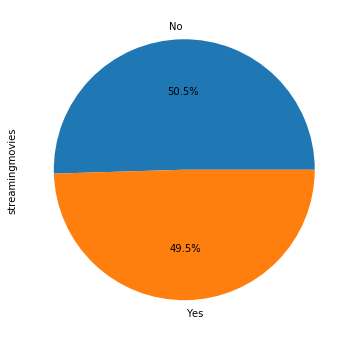

In [14]:
# применим функцию get_all_columns_info к internet
get_all_columns_info(internet)

По данным об интернет-услугах можно сказать о том , что из `7043` клиентов `5517` пользуются интернет-услугами, из них
- больше половины используют оптоволокно;
- `36.6%` пользуются блокировкой небезопасных сайтов;
- `44%` имеет облачное хранилище файлов для резервного копирования данных; 
- `43.9%` пользуются антивирусом;
- у `37%` существует выделенная линия технической поддержки;
- половина использует стриминговое телевидение и каталог фильмов.

______________________________________________

Числовое описание данных столбца "multiplelines"

В столбце нет пропусков

count     6361
unique       2
top         No
freq      3390
Name: multiplelines, dtype: object


Распределение данных столбца "multiplelines"

No     3390
Yes    2971
Name: multiplelines, dtype: int64


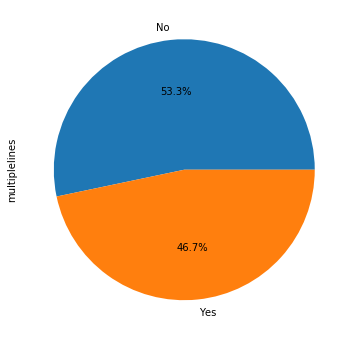

In [15]:
# применим функцию get_all_columns_info к phone
get_all_columns_info(phone)

По данным об услугах телефонии можно сказать о том , что из `7043` клиентов `6361` используют данную услугу. Причем у `46.7%` из них телефонный аппарат 
- больше половины используют оптоволокно;
- `36.6%` пользуются блокировкой небезопасных сайтов;
- `44%` имеет облачное хранилище файлов для резервного копирования данных; 
- `43.9%` пользуются антивирусом;
- у `37%` существует выделенная линия технической поддержки;
- половина использует стриминговое телевидение и каталог фильмов.

In [16]:
# объединим все таблицы в одну
general = contract.join([personal, internet, phone])
general.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
begindate           7043 non-null object
enddate             7043 non-null object
type                7043 non-null object
paperlessbilling    7043 non-null object
paymentmethod       7043 non-null object
monthlycharges      7043 non-null float64
totalcharges        7043 non-null float64
gender              7043 non-null object
seniorcitizen       7043 non-null int64
partner             7043 non-null object
dependents          7043 non-null object
internetservice     5517 non-null object
onlinesecurity      5517 non-null object
onlinebackup        5517 non-null object
deviceprotection    5517 non-null object
techsupport         5517 non-null object
streamingtv         5517 non-null object
streamingmovies     5517 non-null object
multiplelines       6361 non-null object
dtypes: float64(2), int64(1), object(16)
memory usage: 1.4+ MB


In [17]:
# построим на тех, кто отказался от услуг компании
left = general.query('enddate not in "No"')
left.sample(4)

,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
customerID,,,,,,,,,,,,,,,,,,,
6689-KXGBO,2019-09-01,2019-10-01 00:00:00,Month-to-month,No,Electronic check,50.55,50.55,Female,0,No,No,DSL,No,Yes,No,No,No,No,No
6204-IEUXJ,2019-08-01,2019-11-01 00:00:00,Month-to-month,No,Credit card (automatic),80.10,217.55,Female,0,No,No,Fiber optic,No,No,Yes,Yes,No,No,No
1853-UDXBW,2019-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,70.00,70.00,Male,0,Yes,Yes,Fiber optic,No,No,No,No,No,No,No
8808-ELEHO,2019-04-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,81.25,585.95,Male,1,No,No,Fiber optic,No,No,Yes,No,No,No,Yes


In [18]:
# построим на текущих клиентов компании
current = general.query('enddate in "No"')
current.sample(4)

,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
customerID,,,,,,,,,,,,,,,,,,,
1472-TNCWL,2017-02-01,No,Month-to-month,Yes,Electronic check,94.70,3512.50,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,No
4312-GVYNH,2014-04-01,No,Two year,Yes,Bank transfer (automatic),49.85,3370.20,Female,0,Yes,No,DSL,Yes,No,Yes,Yes,No,Yes,NaN
6738-ISCBM,2016-06-01,No,One year,Yes,Electronic check,54.00,2440.25,Male,0,No,No,DSL,Yes,No,Yes,No,Yes,Yes,NaN
7663-ZTEGJ,2017-09-01,No,One year,No,Credit card (automatic),100.55,2830.45,Male,0,No,Yes,Fiber optic,No,Yes,Yes,Yes,No,Yes,Yes


__________________________________________

Числовое описание данных столбца "begindate"

В столбце нет пропусков

count           5174
unique            73
top       2014-02-01
freq             356
Name: begindate, dtype: object

Наиболее частотные значения столбца

2014-02-01    356
2020-01-01    233
2014-03-01    164
2019-12-01    115
2014-04-01    108
Name: begindate, dtype: int64

Наименее частотные значения столбца

2016-06-01    45
2017-10-01    45
2016-11-01    42
2017-02-01    40
2020-02-01    11
Name: begindate, dtype: int64


________________________________________

Числовое описание данных столбца "enddate"

В столбце нет пропусков

count     5174
unique       1
top         No
freq      5174
Name: enddate, dtype: object


Распределение данных столбца "enddate"

No    5174
Name: enddate, dtype: int64


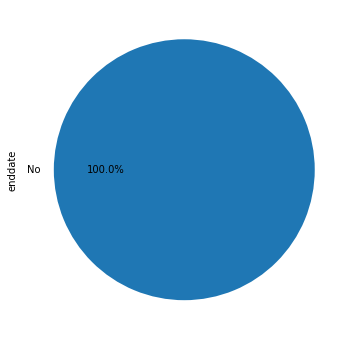

_____________________________________

Числовое описание данных столбца "type"

В столбце нет пропусков

count               5174
unique                 3
top       Month-to-month
freq                2220
Name: type, dtype: object


Распределение данных столбца "type"

Month-to-month    2220
Two year          1647
One year          1307
Name: type, dtype: int64


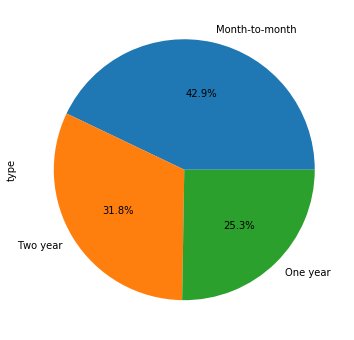

_________________________________________________

Числовое описание данных столбца "paperlessbilling"

В столбце нет пропусков

count     5174
unique       2
top        Yes
freq      2771
Name: paperlessbilling, dtype: object


Распределение данных столбца "paperlessbilling"

Yes    2771
No     2403
Name: paperlessbilling, dtype: int64


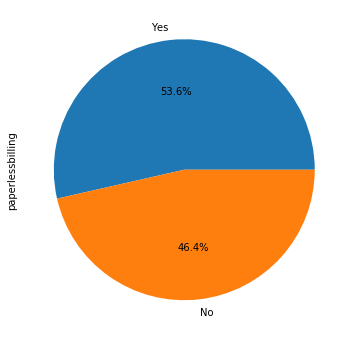

______________________________________________

Числовое описание данных столбца "paymentmethod"

В столбце нет пропусков

count             5174
unique               4
top       Mailed check
freq              1304
Name: paymentmethod, dtype: object


Распределение данных столбца "paymentmethod"

Mailed check                 1304
Electronic check             1294
Credit card (automatic)      1290
Bank transfer (automatic)    1286
Name: paymentmethod, dtype: int64


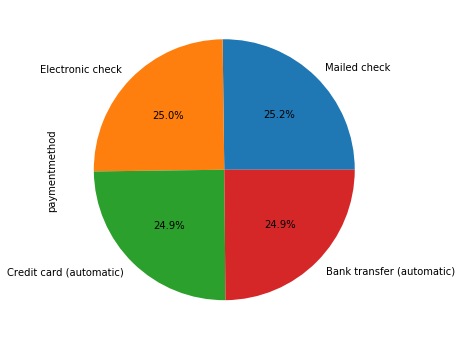

_______________________________________________

Числовое описание данных столбца "monthlycharges"

В столбце нет пропусков

count    5174.000000
mean       61.265124
std        31.092648
min        18.250000
25%        25.100000
50%        64.425000
75%        88.400000
max       118.750000
Name: monthlycharges, dtype: float64

Наиболее частотные значения столбца

20.05    58
19.95    41
19.70    41
20.00    40
19.90    40
Name: monthlycharges, dtype: int64

Наименее частотные значения столбца

46.25     1
114.55    1
68.45     1
51.15     1
111.10    1
Name: monthlycharges, dtype: int64


Максимальные значения столбца

monthlycharges
118.75    1
118.65    1
118.60    2
118.20    1
117.60    1
Name: monthlycharges, dtype: int64

Минимальные значения столбца

monthlycharges
18.75    1
18.70    2
18.55    1
18.40    1
18.25    1
Name: monthlycharges, dtype: int64

Диаграмма размаха столбца monthlycharges


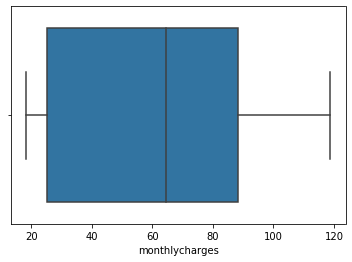


Гистограмма для столбца monthlycharges


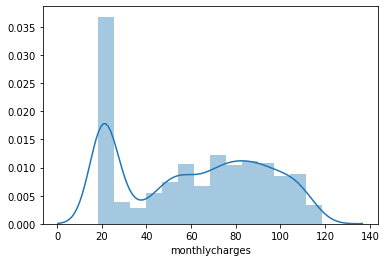

_____________________________________________

Числовое описание данных столбца "totalcharges"

В столбце нет пропусков

count    5174.000000
mean     2549.999497
std      2329.858843
min        18.800000
25%       572.900000
50%      1679.525000
75%      4262.850000
max      8672.450000
Name: totalcharges, dtype: float64

Наиболее частотные значения столбца

19.75    7
20.05    6
19.65    6
19.55    6
20.20    5
Name: totalcharges, dtype: int64

Наименее частотные значения столбца

4862.50    1
1992.95    1
1790.65    1
5980.75    1
97.00      1
Name: totalcharges, dtype: int64


Максимальные значения столбца

totalcharges
8672.45    1
8670.10    1
8594.40    1
8564.75    1
8547.15    1
Name: totalcharges, dtype: int64

Минимальные значения столбца

totalcharges
19.05    1
19.00    1
18.90    1
18.85    1
18.80    1
Name: totalcharges, dtype: int64

Диаграмма размаха столбца totalcharges


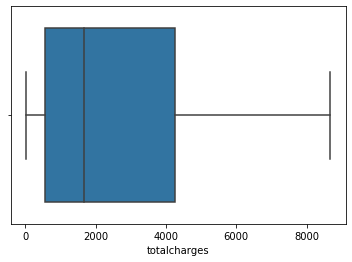


Гистограмма для столбца totalcharges


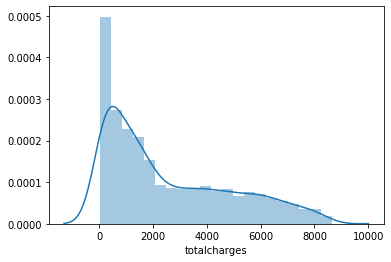

_______________________________________

Числовое описание данных столбца "gender"

В столбце нет пропусков

count     5174
unique       2
top       Male
freq      2625
Name: gender, dtype: object


Распределение данных столбца "gender"

Male      2625
Female    2549
Name: gender, dtype: int64


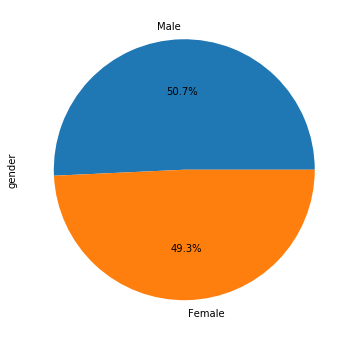

______________________________________________

Числовое описание данных столбца "seniorcitizen"

В столбце нет пропусков

count    5174.000000
mean        0.128721
std         0.334923
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: seniorcitizen, dtype: float64


Распределение данных столбца "seniorcitizen"

0    4508
1     666
Name: seniorcitizen, dtype: int64


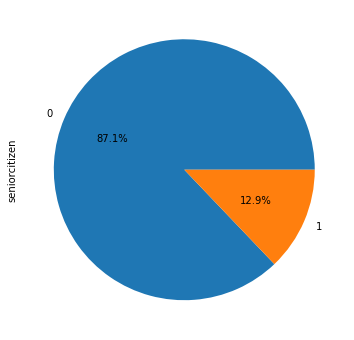

________________________________________

Числовое описание данных столбца "partner"

В столбце нет пропусков

count     5174
unique       2
top        Yes
freq      2733
Name: partner, dtype: object


Распределение данных столбца "partner"

Yes    2733
No     2441
Name: partner, dtype: int64


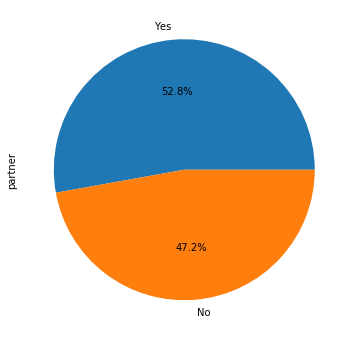

___________________________________________

Числовое описание данных столбца "dependents"

В столбце нет пропусков

count     5174
unique       2
top         No
freq      3390
Name: dependents, dtype: object


Распределение данных столбца "dependents"

No     3390
Yes    1784
Name: dependents, dtype: int64


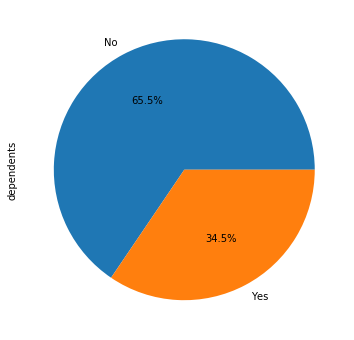

________________________________________________

Числовое описание данных столбца "internetservice"

Количество пропусков: 1413

count     3761
unique       2
top        DSL
freq      1962
Name: internetservice, dtype: object


Распределение данных столбца "internetservice"

DSL            1962
Fiber optic    1799
Name: internetservice, dtype: int64


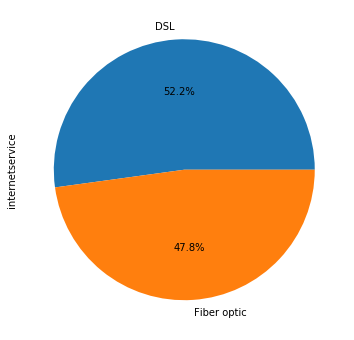

_______________________________________________

Числовое описание данных столбца "onlinesecurity"

Количество пропусков: 1413

count     3761
unique       2
top         No
freq      2037
Name: onlinesecurity, dtype: object


Распределение данных столбца "onlinesecurity"

No     2037
Yes    1724
Name: onlinesecurity, dtype: int64


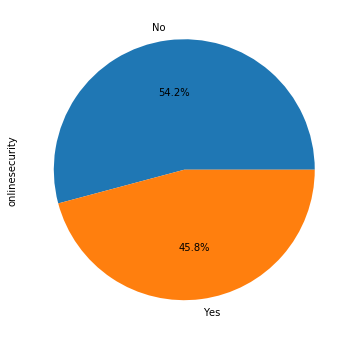

_____________________________________________

Числовое описание данных столбца "onlinebackup"

Количество пропусков: 1413

count     3761
unique       2
top        Yes
freq      1906
Name: onlinebackup, dtype: object


Распределение данных столбца "onlinebackup"

Yes    1906
No     1855
Name: onlinebackup, dtype: int64


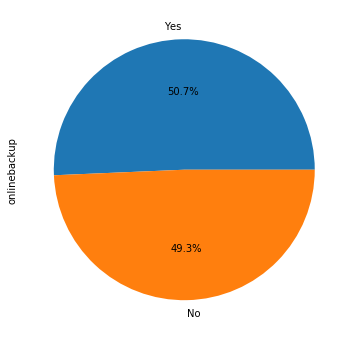

_________________________________________________

Числовое описание данных столбца "deviceprotection"

Количество пропусков: 1413

count     3761
unique       2
top         No
freq      1884
Name: deviceprotection, dtype: object


Распределение данных столбца "deviceprotection"

No     1884
Yes    1877
Name: deviceprotection, dtype: int64


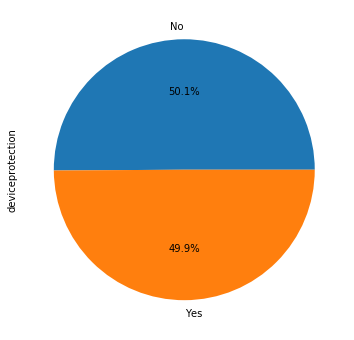

____________________________________________

Числовое описание данных столбца "techsupport"

Количество пропусков: 1413

count     3761
unique       2
top         No
freq      2027
Name: techsupport, dtype: object


Распределение данных столбца "techsupport"

No     2027
Yes    1734
Name: techsupport, dtype: int64


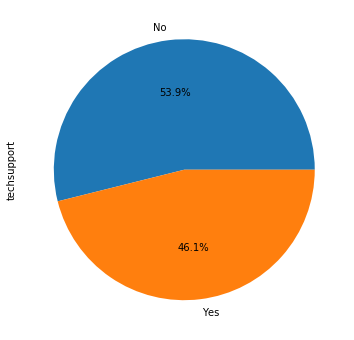

____________________________________________

Числовое описание данных столбца "streamingtv"

Количество пропусков: 1413

count     3761
unique       2
top        Yes
freq      1893
Name: streamingtv, dtype: object


Распределение данных столбца "streamingtv"

Yes    1893
No     1868
Name: streamingtv, dtype: int64


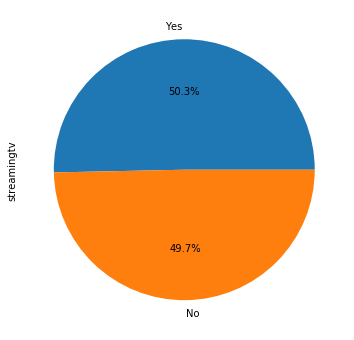

________________________________________________

Числовое описание данных столбца "streamingmovies"

Количество пропусков: 1413

count     3761
unique       2
top        Yes
freq      1914
Name: streamingmovies, dtype: object


Распределение данных столбца "streamingmovies"

Yes    1914
No     1847
Name: streamingmovies, dtype: int64


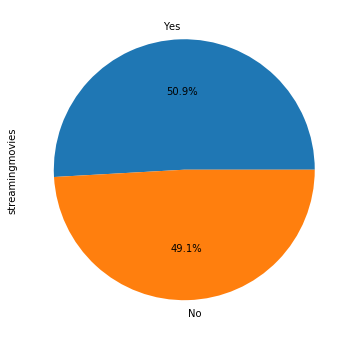

______________________________________________

Числовое описание данных столбца "multiplelines"

Количество пропусков: 512

count     4662
unique       2
top         No
freq      2541
Name: multiplelines, dtype: object


Распределение данных столбца "multiplelines"

No     2541
Yes    2121
Name: multiplelines, dtype: int64


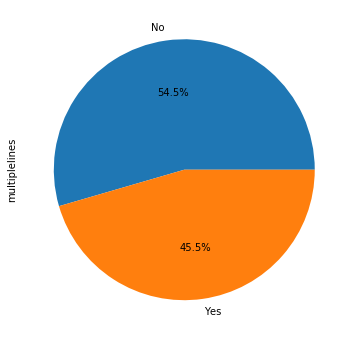

In [19]:
# применим функцию get_all_columns_info к current
get_all_columns_info(current)

По данным о текущих клиентах можно сказать, что клиенты
- чаще используют ежемесячный способ оплаты (`42.9%`);
- одинаково пользуются способами оплаты (по `25%` каждый);
- в среднем каждый клиент тратит `61` в месяц;
- примерно `34.5%` иждивенцев;
- остальные значения распределены примерно в `50%`-м соотношении.

__________________________________________

Числовое описание данных столбца "begindate"

В столбце нет пропусков

count           1869
unique            75
top       2019-09-01
freq             168
Name: begindate, dtype: object

Наиболее частотные значения столбца

2019-09-01    168
2019-10-01    144
2019-11-01    131
2019-12-01    105
2019-07-01     76
Name: begindate, dtype: int64

Наименее частотные значения столбца

2014-09-01    5
2014-10-01    4
2013-12-01    3
2013-10-01    3
2013-11-01    2
Name: begindate, dtype: int64


________________________________________

Числовое описание данных столбца "enddate"

В столбце нет пропусков

count                    1869
unique                      4
top       2019-11-01 00:00:00
freq                      485
Name: enddate, dtype: object


Распределение данных столбца "enddate"

2019-11-01 00:00:00    485
2019-12-01 00:00:00    466
2020-01-01 00:00:00    460
2019-10-01 00:00:00    458
Name: enddate, dtype: int64


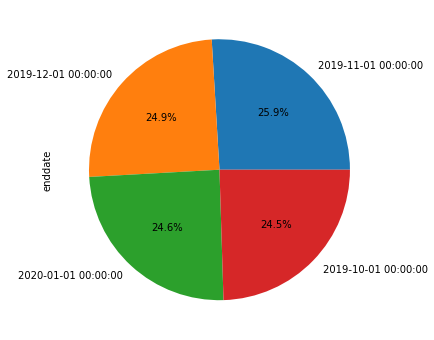

_____________________________________

Числовое описание данных столбца "type"

В столбце нет пропусков

count               1869
unique                 3
top       Month-to-month
freq                1655
Name: type, dtype: object


Распределение данных столбца "type"

Month-to-month    1655
One year           166
Two year            48
Name: type, dtype: int64


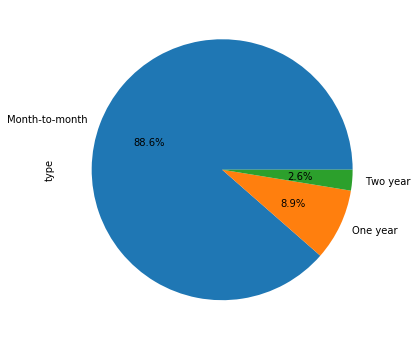

_________________________________________________

Числовое описание данных столбца "paperlessbilling"

В столбце нет пропусков

count     1869
unique       2
top        Yes
freq      1400
Name: paperlessbilling, dtype: object


Распределение данных столбца "paperlessbilling"

Yes    1400
No      469
Name: paperlessbilling, dtype: int64


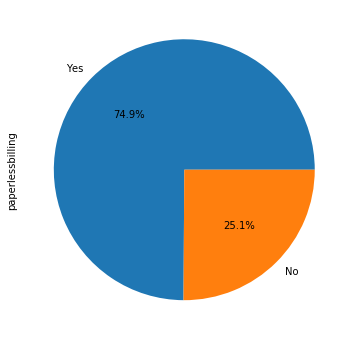

______________________________________________

Числовое описание данных столбца "paymentmethod"

В столбце нет пропусков

count                 1869
unique                   4
top       Electronic check
freq                  1071
Name: paymentmethod, dtype: object


Распределение данных столбца "paymentmethod"

Electronic check             1071
Mailed check                  308
Bank transfer (automatic)     258
Credit card (automatic)       232
Name: paymentmethod, dtype: int64


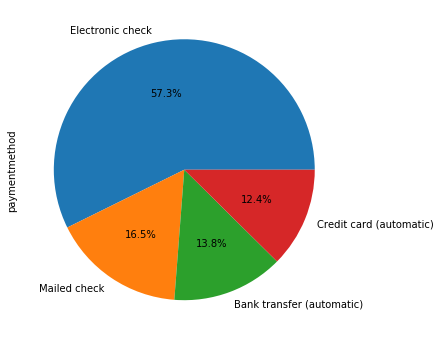

_______________________________________________

Числовое описание данных столбца "monthlycharges"

В столбце нет пропусков

count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: monthlycharges, dtype: float64

Наиболее частотные значения столбца

74.40    13
74.90     9
45.30     8
74.95     8
70.00     7
Name: monthlycharges, dtype: int64

Наименее частотные значения столбца

100.65    1
97.80     1
61.60     1
103.00    1
103.90    1
Name: monthlycharges, dtype: int64


Максимальные значения столбца

monthlycharges
118.35    1
117.80    1
117.45    1
116.20    1
115.65    1
Name: monthlycharges, dtype: int64

Минимальные значения столбца

monthlycharges
19.25    3
19.10    1
19.00    1
18.95    1
18.85    1
Name: monthlycharges, dtype: int64

Диаграмма размаха столбца monthlycharges


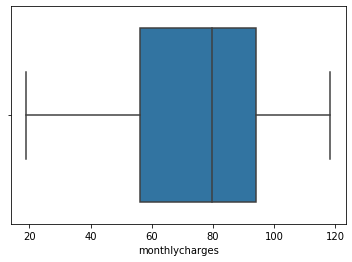


Гистограмма для столбца monthlycharges


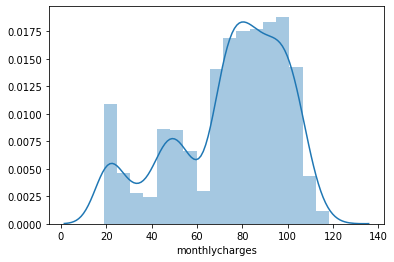

_____________________________________________

Числовое описание данных столбца "totalcharges"

В столбце нет пропусков

count    1869.000000
mean     1531.796094
std      1890.822994
min        18.850000
25%       134.500000
50%       703.550000
75%      2331.300000
max      8684.800000
Name: totalcharges, dtype: float64

Наиболее частотные значения столбца

20.20    6
45.30    5
20.15    4
69.60    4
19.90    4
Name: totalcharges, dtype: int64

Наименее частотные значения столбца

941.00     1
308.25     1
6886.25    1
1527.35    1
389.10     1
Name: totalcharges, dtype: int64


Максимальные значения столбца

totalcharges
8684.80    1
8127.60    1
8109.80    1
7968.85    1
7856.00    1
Name: totalcharges, dtype: int64

Минимальные значения столбца

totalcharges
19.40    1
19.30    2
19.25    1
19.10    1
18.85    1
Name: totalcharges, dtype: int64

Диаграмма размаха столбца totalcharges


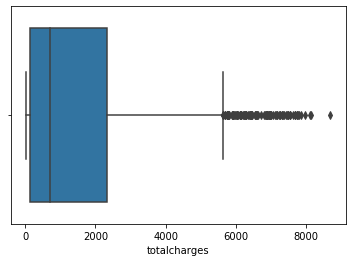


Гистограмма для столбца totalcharges


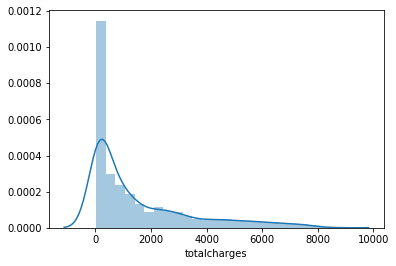

_______________________________________

Числовое описание данных столбца "gender"

В столбце нет пропусков

count       1869
unique         2
top       Female
freq         939
Name: gender, dtype: object


Распределение данных столбца "gender"

Female    939
Male      930
Name: gender, dtype: int64


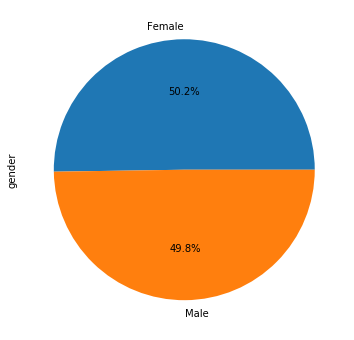

______________________________________________

Числовое описание данных столбца "seniorcitizen"

В столбце нет пропусков

count    1869.000000
mean        0.254682
std         0.435799
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: seniorcitizen, dtype: float64


Распределение данных столбца "seniorcitizen"

0    1393
1     476
Name: seniorcitizen, dtype: int64


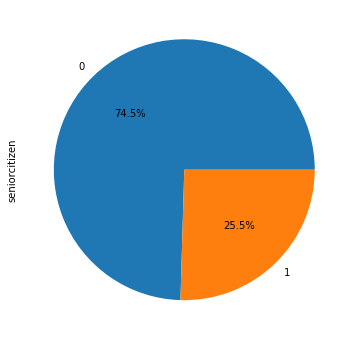

________________________________________

Числовое описание данных столбца "partner"

В столбце нет пропусков

count     1869
unique       2
top         No
freq      1200
Name: partner, dtype: object


Распределение данных столбца "partner"

No     1200
Yes     669
Name: partner, dtype: int64


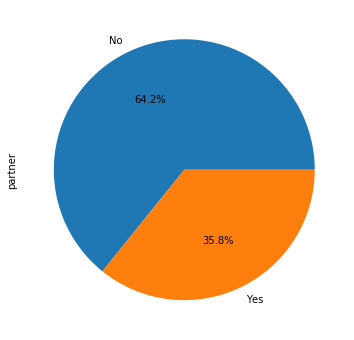

___________________________________________

Числовое описание данных столбца "dependents"

В столбце нет пропусков

count     1869
unique       2
top         No
freq      1543
Name: dependents, dtype: object


Распределение данных столбца "dependents"

No     1543
Yes     326
Name: dependents, dtype: int64


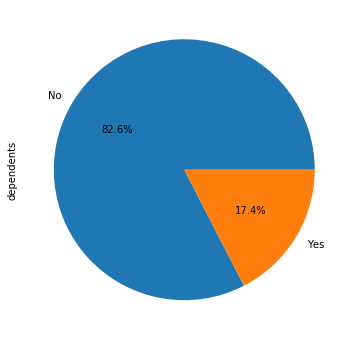

________________________________________________

Числовое описание данных столбца "internetservice"

Количество пропусков: 113

count            1756
unique              2
top       Fiber optic
freq             1297
Name: internetservice, dtype: object


Распределение данных столбца "internetservice"

Fiber optic    1297
DSL             459
Name: internetservice, dtype: int64


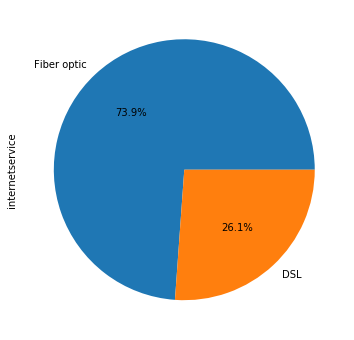

_______________________________________________

Числовое описание данных столбца "onlinesecurity"

Количество пропусков: 113

count     1756
unique       2
top         No
freq      1461
Name: onlinesecurity, dtype: object


Распределение данных столбца "onlinesecurity"

No     1461
Yes     295
Name: onlinesecurity, dtype: int64


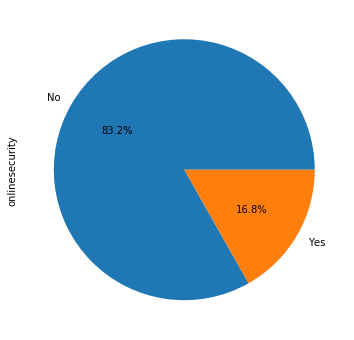

_____________________________________________

Числовое описание данных столбца "onlinebackup"

Количество пропусков: 113

count     1756
unique       2
top         No
freq      1233
Name: onlinebackup, dtype: object


Распределение данных столбца "onlinebackup"

No     1233
Yes     523
Name: onlinebackup, dtype: int64


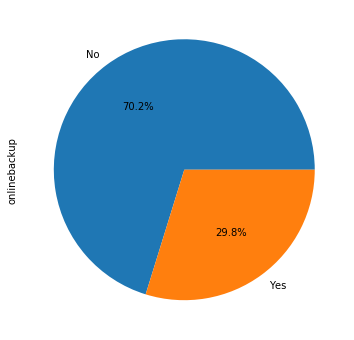

_________________________________________________

Числовое описание данных столбца "deviceprotection"

Количество пропусков: 113

count     1756
unique       2
top         No
freq      1211
Name: deviceprotection, dtype: object


Распределение данных столбца "deviceprotection"

No     1211
Yes     545
Name: deviceprotection, dtype: int64


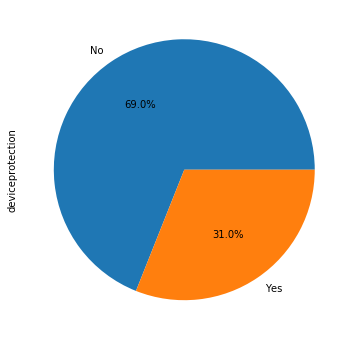

____________________________________________

Числовое описание данных столбца "techsupport"

Количество пропусков: 113

count     1756
unique       2
top         No
freq      1446
Name: techsupport, dtype: object


Распределение данных столбца "techsupport"

No     1446
Yes     310
Name: techsupport, dtype: int64


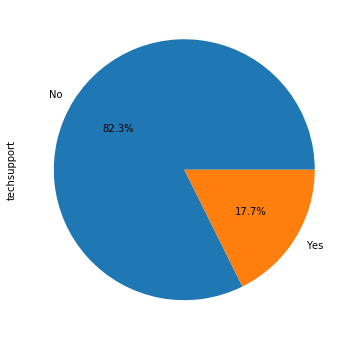

____________________________________________

Числовое описание данных столбца "streamingtv"

Количество пропусков: 113

count     1756
unique       2
top         No
freq       942
Name: streamingtv, dtype: object


Распределение данных столбца "streamingtv"

No     942
Yes    814
Name: streamingtv, dtype: int64


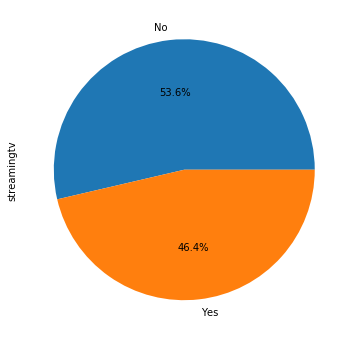

________________________________________________

Числовое описание данных столбца "streamingmovies"

Количество пропусков: 113

count     1756
unique       2
top         No
freq       938
Name: streamingmovies, dtype: object


Распределение данных столбца "streamingmovies"

No     938
Yes    818
Name: streamingmovies, dtype: int64


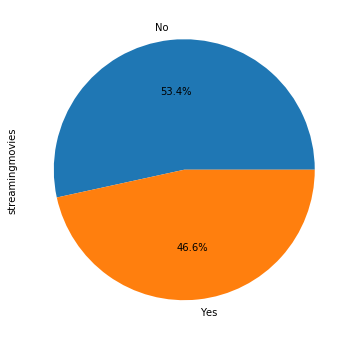

______________________________________________

Числовое описание данных столбца "multiplelines"

Количество пропусков: 170

count     1699
unique       2
top        Yes
freq       850
Name: multiplelines, dtype: object


Распределение данных столбца "multiplelines"

Yes    850
No     849
Name: multiplelines, dtype: int64


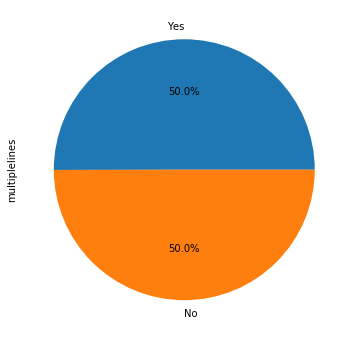

In [20]:
# применим функцию get_all_columns_info к left
get_all_columns_info(left)

По этим данным можно сказать, что присутствует информация об уходе клиентов за последние 4 месяца, причём каждый месяц отток был стабильный, а среди ушедших клиентов (в скобках будут значения для текущих клиентов)
- `88.6%` пользовались ежемесячным платежом (`42.9%`);
- `74.9%` использовали бумажную рассылку (`53.6%`);
- `57.3%` пользовались электронным чеком (`25.0%`);
- в среднем каждый ушедший клиент платил `75` в месяц (`61`);
- `73.9%` использовали оптоволокно (`47.8%`);
- `83.2%` не использовали блокировку небезопасных сайтов (`54.2%`);
- `70.2%` не использовали облачное хранилище файлов для резервного копирования данных (`50.7%`);
- `69.0%` не использовали антивирус (`50.1%`);
- `82.3%` не использовали выделенную линии технической поддержки (`53.9%`);

### Вывод

В результате исследовательнского анализа данных были изучены данные о текущих и ушедших клиентах. Например, удалось установить, что среди ушедших клиентов подавляющее большинство использовало ежемесячный платеж, бумажную рассылку, оптоволокно и не пользовались дополнительными предложениями по безопасности и обслуживанию.

## III. Подготовка данных к обучению

<a id='3-section'></a>
### 1. Подготовка признаков

[Вернуться к оглавлению](#0-section)

In [21]:
# добавим столбец с фактом ухода клиента
def add_exited(value):
    if value in "No":
        return 0
    else:
        return 1
general['exited'] = general['enddate'].apply(add_exited)

In [22]:
def sub_no(value):
    if value in "No":
        return "2020-02-01"
    else:
        return value
general['enddate'] = general['enddate'].apply(sub_no)

In [23]:
# добавим столбец с количеством дней, которые клиент пользовался услугами компании
general['begindate'] = pd.to_datetime(general['begindate'], format='%Y-%m-%d')
general['enddate'] = pd.to_datetime(general['enddate'], format='%Y-%m-%dT%H:%M:%S')

In [24]:
general['days'] = (general['enddate'] - general['begindate']).dt.days

In [25]:
# удалим столбцы "begindate", "enddate"
general = general.drop(["begindate", "enddate"], axis=1)

In [26]:
pip install lofo-importance

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [27]:
from tqdm.autonotebook import tqdm

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """Entry point for launching an IPython kernel.


In [28]:
from lofo import LOFOImportance, Dataset, plot_importance

In [29]:
target="exited"

In [30]:
dataset = Dataset(
    df=general,
    target="exited",
    features=[col for col in general.columns if col != target],
)

In [31]:
# определим схему кроссвалидации и метрику
lofo_imp = LOFOImportance(dataset, cv=5, scoring="roc_auc")

In [32]:
# получить среднее значение и стандартное отклонение значений
importance_df = lofo_imp.get_importance()

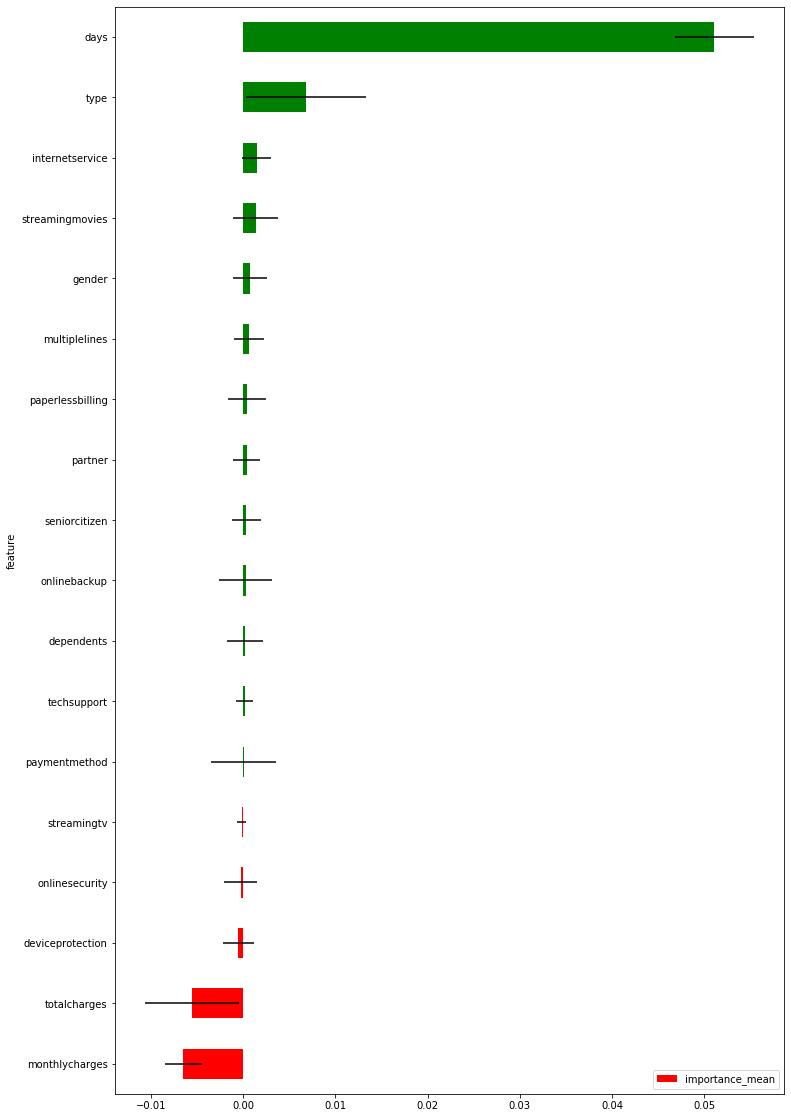

In [33]:
# построим график важности признаков
plot_importance(importance_df, figsize=(12, 20))

In [34]:
# оставим значимые признаки
final = general.drop([
    'partner',
    'dependents',
    'paperlessbilling',
    'deviceprotection',
    'multiplelines',
    'techsupport',
    'streamingtv',
    'gender',
    'paymentmethod',
], axis=1).copy()
final = final.fillna('Nope')

In [35]:
# выделим столбцы с числовыми и категориальными признаками
numeric = [col for col in final.columns if final[col].dtype in ['int64', 'float64'] and col != target]
category = [col for col in final.columns if final[col].dtype in ['object']]

<a id='4-section'></a>
### 2. Разбиение на выборки

[Вернуться к оглавлению](#0-section)

Необходимо преобразовать категориальные признаки в численные. В этом нам поможет One-Hot Encoding (OHE).

In [36]:
def dummies(data):
    data = pd.get_dummies(data, drop_first=True)
    return data

In [37]:
# воспользуемся функцией get_dummies()
final_ohe = dummies(final)

In [38]:
## используем OrdinalEncoder() для преобразования категориальных признаков в числовые
final_oe = final.copy()
enc = OrdinalEncoder()
enc.fit(final[category])
final_oe[category] = pd.DataFrame(enc.transform(final[category]), columns=final[category].columns, index=final[category].index)
final_oe.head()

,type,monthlycharges,totalcharges,seniorcitizen,internetservice,onlinesecurity,onlinebackup,streamingmovies,exited,days
customerID,,,,,,,,,,
7590-VHVEG,0.0,29.85,29.85,0,0.0,0.0,2.0,0.0,0,31
5575-GNVDE,1.0,56.95,1889.50,0,0.0,2.0,0.0,0.0,0,1036
3668-QPYBK,0.0,53.85,108.15,0,0.0,2.0,2.0,0.0,1,61
7795-CFOCW,1.0,42.30,1840.75,0,0.0,2.0,0.0,0.0,0,1371
9237-HQITU,0.0,70.70,151.65,0,1.0,0.0,0.0,0.0,1,61


In [39]:
def get_features_target(data):
    features = data.drop('exited', axis=1)
    target = data['exited']
    features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=0.2, random_state=42, stratify=target)
    print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)
    return features_train, features_test, target_train, target_test

In [40]:
##
fea_train_ohe, fea_test_ohe, tar_train_ohe, tar_test_ohe = get_features_target(final_ohe)

(5634, 14) (1409, 14) (5634,) (1409,)


In [41]:
##
fea_train_oe, fea_test_oe, tar_train_oe, tar_test_oe = get_features_target(final_oe)

(5634, 9) (1409, 9) (5634,) (1409,)


In [42]:
def get_scaler(features_train, features_test):
    # создадим объект структуры данных StandardScaler
    scaler = StandardScaler()
    # сделаем копии выборок
    features_train = features_train.copy()
    features_test = features_test.copy()
    # настроим на обучающей выборке
    scaler.fit(features_train.loc[:, numeric])
    # преобразуем обучающую и валидационную выборки
    features_train.loc[:, numeric] = scaler.transform(features_train.loc[:, numeric])
    features_test.loc[:, numeric] = scaler.transform(features_test.loc[:, numeric])
    display(features_train.head(3))
    return features_train, features_test

In [43]:
fea_train_ohe, fea_test_ohe = get_scaler(fea_train_ohe, fea_test_ohe)

,monthlycharges,totalcharges,seniorcitizen,days,type_One year,type_Two year,internetservice_Fiber optic,internetservice_Nope,onlinesecurity_Nope,onlinesecurity_Yes,onlinebackup_Nope,onlinebackup_Yes,streamingmovies_Nope,streamingmovies_Yes
customerID,,,,,,,,,,,,,,
4950-BDEUX,-0.521976,-0.262290,-0.441773,0.103688,0,0,0,0,0,0,0,0,0,1
7993-NQLJE,0.337478,-0.503674,-0.441773,-0.712030,0,0,1,0,0,1,0,0,0,0
7321-ZNSLA,-0.809013,-0.749929,-0.441773,-0.793602,0,1,0,0,0,1,0,1,0,0


In [44]:
fea_train_oe, fea_test_oe = get_scaler(fea_train_oe, fea_test_oe)

,type,monthlycharges,totalcharges,seniorcitizen,internetservice,onlinesecurity,onlinebackup,streamingmovies,days
customerID,,,,,,,,,
4950-BDEUX,0.0,-0.521976,-0.262290,-0.441773,0.0,0.0,0.0,2.0,0.103688
7993-NQLJE,0.0,0.337478,-0.503674,-0.441773,1.0,2.0,0.0,0.0,-0.712030
7321-ZNSLA,2.0,-0.809013,-0.749929,-0.441773,0.0,2.0,2.0,0.0,-0.793602


### Вывод

На данном этапе работы мы занимались обработкой и подготовкой данных.

В результате чего
- убрали столбцы "begindate", "enddate";
- добавили столбец с количеством дней (сколько дней человек является клиентом);
- добавили столбец с фактом ухода клиента - целевой признак;
- заполнили пропуски значением "Nope";
- построили график важности признаков и оставили наиболее значимые признаки;
- выделили столбцы с числовыми и категориальными признаками;
- преобразовали категориальные признаки в числовые с помощью OHE и OrdinalEncoder;
- разбили данные на обучающую и тестовую выборки;
- масштабировали числовые признаки.

Данные подготовлены к дальнейшему обучению.

## IV. Исследование моделей классификации

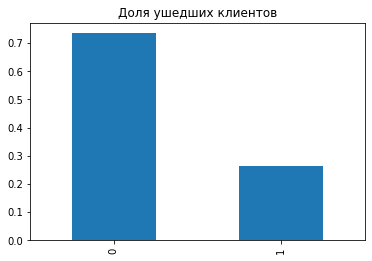

In [45]:
# посмотрим долю ушедших клиентов
final['exited'].value_counts(normalize=True).plot(kind='bar', title='Доля ушедших клиентов')
plt.show()

In [46]:
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

In [47]:
# напишем функцию для моделей с использованием GridSearchCV()
def get_best_model(model, parameters, x_train, x_test, y_train, y_test):
    clf = GridSearchCV(estimator=model, param_grid=parameters, cv=5, verbose=1, n_jobs=-1, scoring=roc_auc_scorer)
    clf.fit(x_train, y_train)
    best_model = clf.best_estimator_
    best_model.fit(x_train, y_train)
    pred_train = best_model.predict(x_train)
    pred_test = best_model.predict(x_test)
    print('Лучшие параметры модели:', clf.best_params_)
    print()
    print('Матрица ошибок:')
    sns.heatmap(confusion_matrix(y_train, pred_train), annot=True, fmt="d")
    plt.show()
    print()
    # вычислим значение полноты, точности, F1-меры модели
    accuracy_train = accuracy_score(y_train, pred_train)
    recall_train = recall_score(y_train, pred_train)
    precision_train = precision_score(y_train, pred_train)
    f1_train = f1_score(y_train, pred_train)
    accuracy_test = accuracy_score(y_test, pred_test)
    recall_test = recall_score(y_test, pred_test)
    precision_test = precision_score(y_test, pred_test)
    f1_test = f1_score(y_test, pred_test)
    # вычислим значение AUC-ROC
    probabilities_train = best_model.predict_proba(x_train)
    probabilities_one_train = probabilities_train[:, 1]
    roc_auc_train = roc_auc_score(y_train, probabilities_one_train)
    probabilities_test = best_model.predict_proba(x_test)
    probabilities_one_test = probabilities_test[:, 1]
    roc_auc_test = roc_auc_score(y_test, probabilities_one_test)
    print('"ROC-AUC" на обучающей выборке: {}'.format(roc_auc_train))
    print('"ROC-AUC" на тестовой выборке: {}'.format(roc_auc_test))
    df = pd.DataFrame(data=[[accuracy_train,accuracy_test], 
                            [recall_train,recall_test], 
                            [precision_train,precision_test], 
                            [f1_train,f1_test], 
                            [roc_auc_train,roc_auc_test]], 
                      index=['accuracy', 'recall', 'precision', 'f1', 'roc_auc'], 
                      columns=['Метрики на обучающей выборке','Метрики на тестовой выборке'])
    display(df)
    return best_model, df, probabilities_one_test

<a id='5-section'></a>
### 1. Константная модель

[Вернуться к оглавлению](#0-section)

In [48]:
# определим точность предсказания константной модели
def dummy_model(x_train, x_test, y_train, y_test, constant):
    # константная модель, всегда предсказывающая значение по выбранной стратегии
    dummy = DummyClassifier(strategy='constant', constant=constant, random_state=42)
    dummy.fit(x_train, y_train)
    pred_test = dummy.predict(x_test)
    # вычислим значение точности, полноты, F1-меры и AUC-ROC константной модели
    accuracy = accuracy_score(y_test, pred_test)
    recall = recall_score(y_test, pred_test)
    precision = precision_score(y_test, pred_test)
    f1 = f1_score(y_test, pred_test)
    dummy_probabilities_test = dummy.predict_proba(x_test)
    dummy_probabilities_one_test = dummy_probabilities_test[:, 1]
    auc_roc = roc_auc_score(y_test, dummy_probabilities_one_test)
    df = pd.DataFrame(data=[[accuracy], 
                            [recall], 
                            [precision], 
                            [f1], 
                            [auc_roc]], 
                      index=['accuracy', 'recall', 'precision', 'f1', 'roc_auc'], 
                      columns=['Значения метрик'])
    return df

In [49]:
dummy_0 = dummy_model(fea_train_ohe, fea_test_ohe, tar_train_ohe, tar_test_ohe, 0)
dummy_0

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Значения метрик
accuracy,0.734564
recall,0.000000
precision,0.000000
f1,0.000000
roc_auc,0.500000


In [50]:
dummy_1 = dummy_model(fea_train_ohe, fea_test_ohe, tar_train_ohe, tar_test_ohe, 1)
dummy_1

,Значения метрик
accuracy,0.265436
recall,1.000000
precision,0.265436
f1,0.419518
roc_auc,0.500000


Лучший результат метрики "ROC-AUC" константной модели - `0.5`.

<a id='6-section'></a>
### 2. Дисбаланс классов

[Вернуться к оглавлению](#0-section)

In [51]:
# создадим словарь для логистической регрессии
param_log_reg = {
    "C": list(range(1, 100, 1)),
    "random_state": [42],
}

def log_reg(features_train, features_test, target_train, target_test, class_weight):
    # используем функцию get_best_model()
    lr_model, lr_df, lr_proba = get_best_model(
        LogisticRegression(solver="liblinear", class_weight=class_weight),
        param_log_reg,
        features_train,
        features_test,
        target_train,
        target_test,
    )
    return lr_model, lr_df, lr_proba

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:  1.6min finished


Лучшие параметры модели: {'C': 4, 'random_state': 42}

Матрица ошибок:


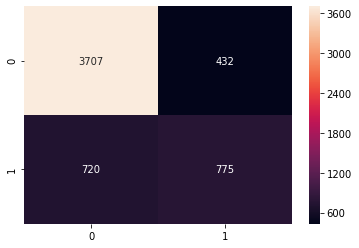


"ROC-AUC" на обучающей выборке: 0.8412347350958862
"ROC-AUC" на тестовой выборке: 0.839138184918236


,Метрики на обучающей выборке,Метрики на тестовой выборке
accuracy,0.795527,0.794180
recall,0.518395,0.529412
precision,0.642088,0.634615
f1,0.573649,0.577259
roc_auc,0.841235,0.839138


CPU times: user 50.5 s, sys: 48.5 s, total: 1min 38s
Wall time: 1min 39s


In [52]:
%%time
lr_model_disb, lr_df_disb, lr_proba_disb = log_reg(
    fea_train_ohe,
    fea_test_ohe, 
    tar_train_ohe,
    tar_test_ohe,
    None
)

In [53]:
# создадим словарь для решающего дерева
param_dec_tree = {
    'max_depth'         : list(range(1, 20, 1)),
    'min_samples_split' : list(range(2, 5, 1)),
    'min_samples_leaf'  : list(range(1, 5, 1)), 
    'random_state'      : [42],
}
# используем функцию get_best_model()
def dec_tree(features_train, features_test, target_train, target_test, class_weight):
    # используем функцию get_best_model()
    dt_model, dt_df, dt_proba = get_best_model(
        DecisionTreeClassifier(class_weight=class_weight),
        param_dec_tree,
        features_train,
        features_test,
        target_train,
        target_test,
    )
    return dt_model, dt_df, dt_proba

Fitting 5 folds for each of 228 candidates, totalling 1140 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1140 out of 1140 | elapsed:   23.6s finished


Лучшие параметры модели: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 3, 'random_state': 42}

Матрица ошибок:


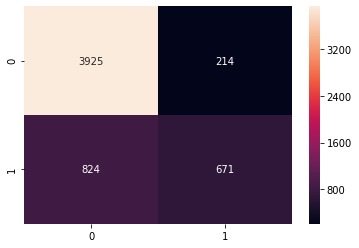


"ROC-AUC" на обучающей выборке: 0.8671179036831316
"ROC-AUC" на тестовой выборке: 0.8448074091296598


,Метрики на обучающей выборке,Метрики на тестовой выборке
accuracy,0.815761,0.800568
recall,0.448829,0.419786
precision,0.758192,0.710407
f1,0.563866,0.527731
roc_auc,0.867118,0.844807


CPU times: user 23.5 s, sys: 65.9 ms, total: 23.6 s
Wall time: 24.1 s


In [54]:
%%time
dt_model_disb, dt_df_disb, dt_proba_disb = dec_tree(
    fea_train_oe,
    fea_test_oe, 
    tar_train_oe,
    tar_test_oe,
    None
)

In [55]:
# создадим словарь для случайного леса
param_rand_for = {
    'n_estimators'      : list(range(1, 120, 5)),
    'max_depth'         : list(range(1, 15, 1)), 
    'random_state'      : [42],
}
# используем функцию get_best_model()
def rand_for(features_train, features_test, target_train, target_test, class_weight):
    # используем функцию get_best_model()
    rand_for_model, rf_df, rf_proba = get_best_model(
        RandomForestClassifier(class_weight=class_weight),
        param_rand_for,
        features_train,
        features_test,
        target_train,
        target_test,
    )
    return rand_for_model, rf_df, rf_proba

Fitting 5 folds for each of 336 candidates, totalling 1680 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1680 out of 1680 | elapsed:  9.0min finished


Лучшие параметры модели: {'max_depth': 9, 'n_estimators': 91, 'random_state': 42}

Матрица ошибок:


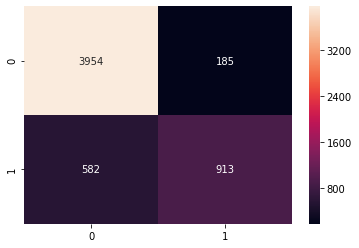


"ROC-AUC" на обучающей выборке: 0.9399124568405113
"ROC-AUC" на тестовой выборке: 0.8571107494381152


,Метрики на обучающей выборке,Метрики на тестовой выборке
accuracy,0.863862,0.816182
recall,0.610702,0.502674
precision,0.831512,0.720307
f1,0.704204,0.592126
roc_auc,0.939912,0.857111


CPU times: user 8min 48s, sys: 1.58 s, total: 8min 50s
Wall time: 9min 2s


In [56]:
%%time
rf_model_disb, rf_df_disb, rf_proba_disb = rand_for(
    fea_train_oe,
    fea_test_oe, 
    tar_train_oe,
    tar_test_oe,
    None
)

In [57]:
# создадим словарь для xgboost
param_xgb = {
    "n_estimators": list(range(40, 120, 5)),
    "max_depth": list(range(1, 5, 1)),
    'objective':['binary:logistic'],
    'gamma':[0,0.2],
    'eta':[0.1,0.07,0.06],
}
# используем функцию get_best_model()
def xgb(features_train, features_test, target_train, target_test, class_weight):
    xgb_model, xgb_df, xgb_proba = get_best_model(
        XGBClassifier(use_label_encoder=False, verbosity = 0, random_state=42, silent=True, class_weight=class_weight),
        param_xgb,
        features_train,
        features_test,
        target_train,
        target_test,
    )
    return xgb_model, xgb_df, xgb_proba

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  7.3min finished


Лучшие параметры модели: {'eta': 0.1, 'gamma': 0, 'max_depth': 4, 'n_estimators': 115, 'objective': 'binary:logistic'}

Матрица ошибок:


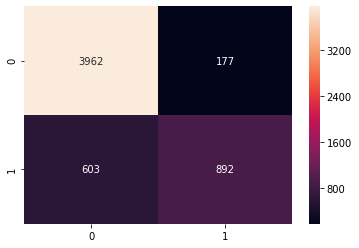


"ROC-AUC" на обучающей выборке: 0.9216126720218236
"ROC-AUC" на тестовой выборке: 0.8903614146580899


,Метрики на обучающей выборке,Метрики на тестовой выборке
accuracy,0.861555,0.840312
recall,0.596656,0.540107
precision,0.834425,0.792157
f1,0.695788,0.642289
roc_auc,0.921613,0.890361


CPU times: user 7min 8s, sys: 1.89 s, total: 7min 10s
Wall time: 7min 20s


In [58]:
%%time
xgb_model_disb, xgb_df_disb, xgb_proba_disb = xgb(
    fea_train_oe,
    fea_test_oe, 
    tar_train_oe,
    tar_test_oe,
    None
)

In [59]:
# создадим словарь для lightgbm
param_lgb = {
    "n_estimators": list(range(72, 150, 3)),
    "max_depth": list(range(1, 20, 1)),
}
# используем функцию get_best_model()
def lgb(features_train, features_test, target_train, target_test, class_weight):
    lgb_model, lgb_df, lgb_proba = get_best_model(
        LGBMClassifier(
            boosting_type="gbdt",
            verbosity=0,
            objective="binary",
            feature_fraction=0.9,
            random_state=42,
            silent=True,
            class_weight=class_weight,
        ),
        param_lgb,
        features_train,
        features_test,
        target_train,
        target_test,
    )
    return lgb_model, lgb_df, lgb_proba

Fitting 5 folds for each of 494 candidates, totalling 2470 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 2470 out of 2470 | elapsed:  7.1min finished


Лучшие параметры модели: {'max_depth': 19, 'n_estimators': 144}

Матрица ошибок:


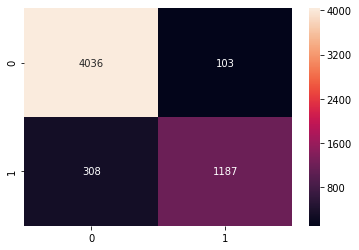


"ROC-AUC" на обучающей выборке: 0.9784564154817419
"ROC-AUC" на тестовой выборке: 0.8990932341315973


,Метрики на обучающей выборке,Метрики на тестовой выборке
accuracy,0.927050,0.853797
recall,0.793980,0.606952
precision,0.920155,0.793706
f1,0.852424,0.687879
roc_auc,0.978456,0.899093


CPU times: user 6min 43s, sys: 20 s, total: 7min 3s
Wall time: 7min 7s


In [60]:
%%time
lgb_model_disb, lgb_df_disb, lgb_proba_disb = lgb(
    fea_train_oe,
    fea_test_oe, 
    tar_train_oe,
    tar_test_oe,
    None
)

In [82]:
# создадим словарь для catboost
param_ctb = {
    "depth": list(range(1, 16, 1)),
}
# используем функцию get_best_model()
def ctb(features_train, features_test, target_train, target_test):
    ctb_model, ctb_df, ctb_proba = get_best_model(
        CatBoostClassifier(learning_rate=0.05, 
                           iterations=40, 
                           verbose=False),
        param_ctb,
        features_train,
        features_test,
        target_train,
        target_test,
    )
    return ctb_model, ctb_df, ctb_proba

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  4.5min finished


Лучшие параметры модели: {'depth': 7}

Матрица ошибок:


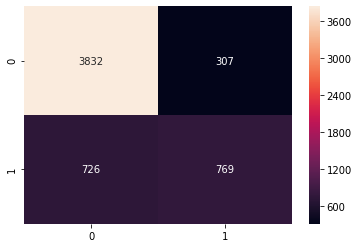


"ROC-AUC" на обучающей выборке: 0.8623275135528674
"ROC-AUC" на тестовой выборке: 0.8520912449301196


,Метрики на обучающей выборке,Метрики на тестовой выборке
accuracy,0.816649,0.811214
recall,0.514381,0.494652
precision,0.714684,0.706107
f1,0.598211,0.581761
roc_auc,0.862328,0.852091


CPU times: user 2min 22s, sys: 23.9 s, total: 2min 46s
Wall time: 4min 34s


In [83]:
%%time
ctb_model_disb, ctb_df_disb, ctb_proba_disb = ctb(
    fea_train_oe,
    fea_test_oe, 
    tar_train_oe,
    tar_test_oe
)

Первичные результаты на дисбалансе данных уже показали приемлимые результаты. Модели градиентного бустинга отработали лучше логистической регрессии и деревьев. Так, метрика ROC-AUC на модели LightGBM достигла значения `0.899`. Такого результата удалось достичь на параметрах `max_depth = 19` и `n_estimators = 144`. Далее, сбалансируем классы и посмотрим на значения метрик.

<a id='7-section'></a>
### 3. Баланс классов

[Вернуться к оглавлению](#0-section)

In [63]:
## используем технику upsampling увеличения выборки
def upsample(features, target):
    # разделим обучающую выборку на отрицательные и положительные объекты
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    # скопируем несколько раз положительные объекты, создаем новую обучающую выборку
    features_upsampled = pd.concat([features_zeros] + [features_ones] * round(len(features_zeros) / len(features_ones)))
    target_upsampled = pd.concat([target_zeros] + [target_ones] * round(len(features_zeros) / len(features_ones)))
    # перемешиваем данные
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=42)
    
    return features_upsampled, target_upsampled

In [64]:
## получили новую обучающую выборку
fea_train_up_ohe, tar_train_up_ohe = upsample(fea_train_ohe, tar_train_ohe)

In [65]:
fea_train_up_oe, tar_train_up_oe = upsample(fea_train_oe, tar_train_oe)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:  1.7min finished


Лучшие параметры модели: {'C': 15, 'random_state': 42}

Матрица ошибок:


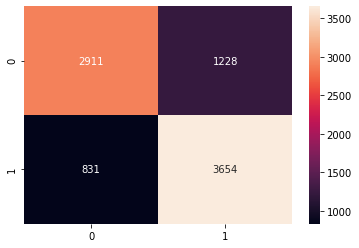


"ROC-AUC" на обучающей выборке: 0.8410383811383843
"ROC-AUC" на тестовой выборке: 0.8381384174223049


,Метрики на обучающей выборке,Метрики на тестовой выборке
accuracy,0.761248,0.726047
recall,0.814716,0.796791
precision,0.748464,0.490132
f1,0.780186,0.606925
roc_auc,0.841038,0.838138


CPU times: user 52.1 s, sys: 47.7 s, total: 1min 39s
Wall time: 1min 40s


In [66]:
%%time
lr_model_up, lr_df_up, lr_proba_up = log_reg(
    fea_train_up_ohe,
    fea_test_ohe, 
    tar_train_up_ohe,
    tar_test_ohe,
    None
)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:  1.7min finished


Лучшие параметры модели: {'C': 6, 'random_state': 42}

Матрица ошибок:


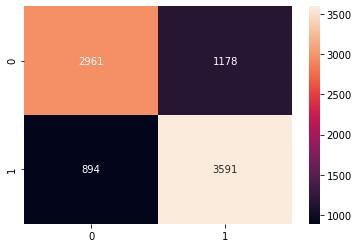


"ROC-AUC" на обучающей выборке: 0.841056319648082
"ROC-AUC" на тестовой выборке: 0.8381926683716965


,Метрики на обучающей выборке,Метрики на тестовой выборке
accuracy,0.759740,0.734564
recall,0.800669,0.796791
precision,0.752988,0.500000
f1,0.776097,0.614433
roc_auc,0.841056,0.838193


In [67]:
lr_model_bal, lr_df_bal, lr_proba_bal = log_reg(
    fea_train_up_ohe,
    fea_test_ohe, 
    tar_train_up_ohe,
    tar_test_ohe,
    'balanced',
)

Fitting 5 folds for each of 228 candidates, totalling 1140 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1140 out of 1140 | elapsed:   42.7s finished


Лучшие параметры модели: {'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42}

Матрица ошибок:


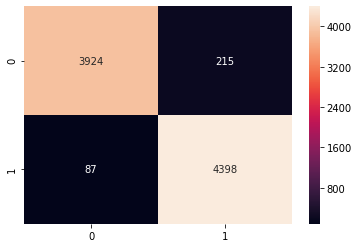


"ROC-AUC" на обучающей выборке: 0.9961891979466063
"ROC-AUC" на тестовой выборке: 0.7457077165517063


,Метрики на обучающей выборке,Метрики на тестовой выборке
accuracy,0.964981,0.776437
recall,0.980602,0.628342
precision,0.953393,0.571776
f1,0.966806,0.598726
roc_auc,0.996189,0.745708


CPU times: user 42.2 s, sys: 138 ms, total: 42.4 s
Wall time: 43.3 s


In [68]:
%%time
dt_model_up, dt_df_up, dt_proba_up = dec_tree(
    fea_train_up_oe,
    fea_test_oe, 
    tar_train_up_oe,
    tar_test_oe,
    None
)

Fitting 5 folds for each of 228 candidates, totalling 1140 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1140 out of 1140 | elapsed:   43.0s finished


Лучшие параметры модели: {'max_depth': 17, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42}

Матрица ошибок:


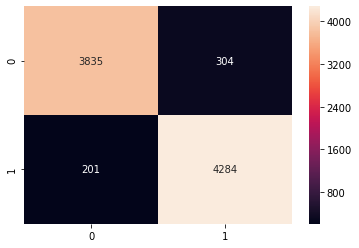


"ROC-AUC" на обучающей выборке: 0.990271348240612
"ROC-AUC" на тестовой выборке: 0.7448461598077967


,Метрики на обучающей выборке,Метрики на тестовой выборке
accuracy,0.941442,0.759404
recall,0.955184,0.631016
precision,0.933740,0.540046
f1,0.944340,0.581998
roc_auc,0.990271,0.744846


CPU times: user 42.8 s, sys: 75.2 ms, total: 42.9 s
Wall time: 43.5 s


In [69]:
%%time
dt_model_bal, dt_df_bal, dt_proba_bal = dec_tree(
    fea_train_up_oe,
    fea_test_oe, 
    tar_train_up_oe,
    tar_test_oe,
    'balanced'
)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1680 out of 1680 | elapsed: 12.0min finished


Лучшие параметры модели: {'max_depth': 14, 'n_estimators': 116, 'random_state': 42}

Матрица ошибок:


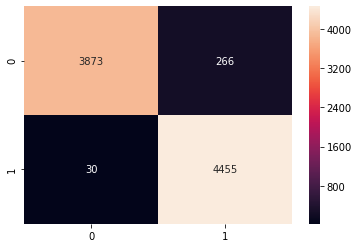


"ROC-AUC" на обучающей выборке: 0.9981731001542549
"ROC-AUC" на тестовой выборке: 0.8452310832106229


,Метрики на обучающей выборке,Метрики на тестовой выборке
accuracy,0.965677,0.775018
recall,0.993311,0.673797
precision,0.943656,0.563758
f1,0.967847,0.613886
roc_auc,0.998173,0.845231


CPU times: user 11min 43s, sys: 1.42 s, total: 11min 44s
Wall time: 12min 4s


In [70]:
%%time
rf_model_up, rf_df_up, rf_proba_up = rand_for(
    fea_train_up_oe,
    fea_test_oe, 
    tar_train_up_oe,
    tar_test_oe,
    None
)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1680 out of 1680 | elapsed: 12.0min finished


Лучшие параметры модели: {'max_depth': 14, 'n_estimators': 91, 'random_state': 42}

Матрица ошибок:


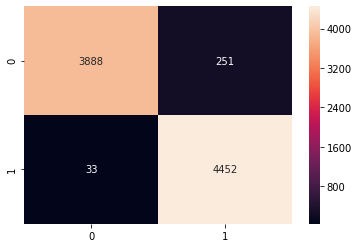


"ROC-AUC" на обучающей выборке: 0.998122355180876
"ROC-AUC" на тестовой выборке: 0.8461197654292284


,Метрики на обучающей выборке,Метрики на тестовой выборке
accuracy,0.967069,0.771469
recall,0.992642,0.668449
precision,0.946630,0.558036
f1,0.969090,0.608273
roc_auc,0.998122,0.846120


CPU times: user 11min 48s, sys: 1.85 s, total: 11min 50s
Wall time: 12min 4s


In [71]:
%%time
rf_model_bal, rf_df_bal, rf_proba_bal = rand_for(
    fea_train_up_oe,
    fea_test_oe, 
    tar_train_up_oe,
    tar_test_oe,
    'balanced'
)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed: 10.8min finished


Лучшие параметры модели: {'eta': 0.1, 'gamma': 0.2, 'max_depth': 4, 'n_estimators': 115, 'objective': 'binary:logistic'}

Матрица ошибок:


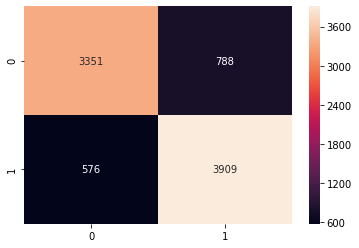


"ROC-AUC" на обучающей выборке: 0.9265068954176804
"ROC-AUC" на тестовой выборке: 0.8966596915446021


,Метрики на обучающей выборке,Метрики на тестовой выборке
accuracy,0.841837,0.801278
recall,0.871572,0.820856
precision,0.832233,0.590385
f1,0.851448,0.686801
roc_auc,0.926507,0.896660


CPU times: user 10min 30s, sys: 1.71 s, total: 10min 32s
Wall time: 10min 50s


In [72]:
%%time
xgb_model_up, xgb_df_up, xgb_proba_up = xgb(
    fea_train_up_oe,
    fea_test_oe, 
    tar_train_up_oe,
    tar_test_oe,
    None
)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed: 10.5min finished


Лучшие параметры модели: {'eta': 0.1, 'gamma': 0.2, 'max_depth': 4, 'n_estimators': 115, 'objective': 'binary:logistic'}

Матрица ошибок:


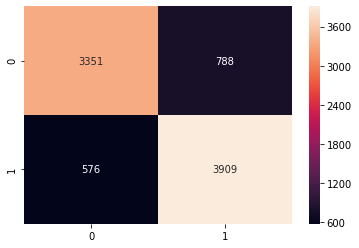


"ROC-AUC" на обучающей выборке: 0.9265068954176804
"ROC-AUC" на тестовой выборке: 0.8966596915446021


,Метрики на обучающей выборке,Метрики на тестовой выборке
accuracy,0.841837,0.801278
recall,0.871572,0.820856
precision,0.832233,0.590385
f1,0.851448,0.686801
roc_auc,0.926507,0.896660


CPU times: user 10min 26s, sys: 1.71 s, total: 10min 28s
Wall time: 10min 35s


In [73]:
%%time
xgb_model_bal, xgb_df_bal, xgb_proba_bal = xgb(
    fea_train_up_oe,
    fea_test_oe, 
    tar_train_up_oe,
    tar_test_oe,
    'balanced'
)

Fitting 5 folds for each of 494 candidates, totalling 2470 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 2470 out of 2470 | elapsed:  8.6min finished


Лучшие параметры модели: {'max_depth': 18, 'n_estimators': 147}

Матрица ошибок:


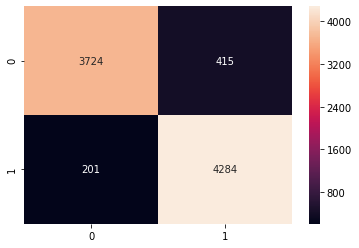


"ROC-AUC" на обучающей выборке: 0.9825838079900706
"ROC-AUC" на тестовой выборке: 0.9091257847012323


,Метрики на обучающей выборке,Метрики на тестовой выборке
accuracy,0.928571,0.839603
recall,0.955184,0.778075
precision,0.911683,0.670507
f1,0.932927,0.720297
roc_auc,0.982584,0.909126


CPU times: user 8min 12s, sys: 19.1 s, total: 8min 32s
Wall time: 8min 37s


In [74]:
%%time
lgb_model_up, lgb_df_up, lgb_proba_up = lgb(
    fea_train_up_oe,
    fea_test_oe, 
    tar_train_up_oe,
    tar_test_oe,
    None
)

Fitting 5 folds for each of 494 candidates, totalling 2470 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 2470 out of 2470 | elapsed:  8.9min finished


Лучшие параметры модели: {'max_depth': 17, 'n_estimators': 147}

Матрица ошибок:


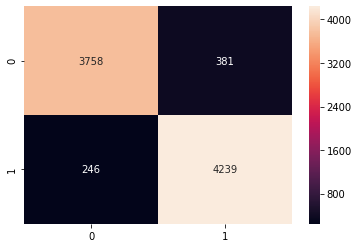


"ROC-AUC" на обучающей выборке: 0.9831394977702109
"ROC-AUC" на тестовой выборке: 0.9111860290888424


,Метрики на обучающей выборке,Метрики на тестовой выборке
accuracy,0.927296,0.849539
recall,0.945151,0.772727
precision,0.917532,0.694712
f1,0.931137,0.731646
roc_auc,0.983139,0.911186


CPU times: user 8min 27s, sys: 20 s, total: 8min 47s
Wall time: 8min 56s


In [75]:
%%time
lgb_model_bal, lgb_df_bal, lgb_proba_bal = lgb(
    fea_train_up_oe,
    fea_test_oe, 
    tar_train_up_oe,
    tar_test_oe,
    'balanced'
)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  6.2min finished


Лучшие параметры модели: {'depth': 14}

Матрица ошибок:


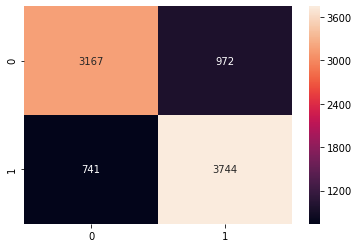


"ROC-AUC" на обучающей выборке: 0.8825225584839859
"ROC-AUC" на тестовой выборке: 0.849018316153866


,Метрики на обучающей выборке,Метрики на тестовой выборке
accuracy,0.801368,0.760114
recall,0.834783,0.791444
precision,0.793893,0.532374
f1,0.813825,0.636559
roc_auc,0.882523,0.849018


CPU times: user 3min 40s, sys: 31 s, total: 4min 11s
Wall time: 6min 29s


In [84]:
%%time
ctb_model_up, ctb_df_up, ctb_proba_up = ctb(
    fea_train_up_oe,
    fea_test_oe, 
    tar_train_up_oe,
    tar_test_oe
)

Для сбалансированной выборки результаты метрики ROC-AUC стали лучше.

Модель градиентного бустинга LightGBM улучшила показатель с `0.899` до `0.911`.

<a id='8-section'></a>
## 4. Визуализация метрик

[Вернуться к оглавлению](#0-section)

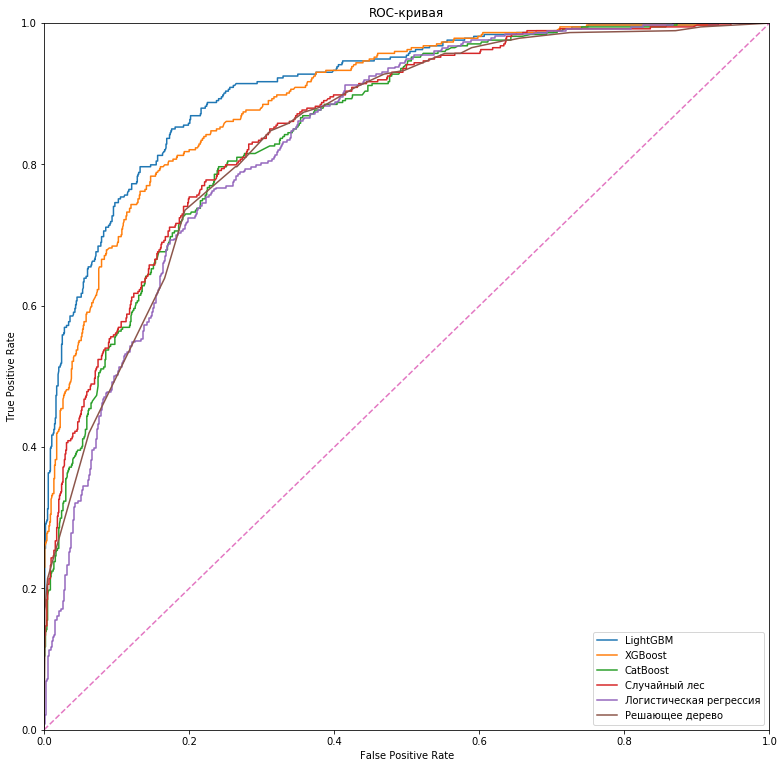

In [86]:
# построим ROC-кривую
# для сравнения на графике представлена ROC-кривая случайной модели
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(
    tar_test_oe, lgb_proba_bal)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(
    tar_test_oe, xgb_proba_bal)
fpr_ctb, tpr_ctb, thresholds_ctb = roc_curve(
    tar_test_oe, ctb_proba_disb)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(
    tar_test_oe, rf_proba_disb)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(
    tar_test_oe, lr_proba_disb)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(
    tar_test_oe, dt_proba_disb)
plt.figure(figsize=(13, 13))
plt.plot(fpr_lgb, tpr_lgb, label='LightGBM')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot(fpr_ctb, tpr_ctb, label='CatBoost')
plt.plot(fpr_rf, tpr_rf, label='Случайный лес')
plt.plot(fpr_lr, tpr_lr, label='Логистическая регрессия')
plt.plot(fpr_dt, tpr_dt, label='Решающее дерево')
plt.legend()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

По графику видно, что модели градиентного бустинга LightGBM и XGBoost показали себя лучше моделей логистической регрессии и деревьев. При этом стоит отметить, что все модели показали себя значительно лучше константной модели.

<a id='9-section'></a>
## V. Общий вывод

В данной работе решалась задача оттока клиента оператора сотовой связи. Заказчик выдал критерий оценивания модели, предсказывающей уйдет клиент в ближайшее время или нет:
Критерии оценки:

- AUC-ROC < 0.75 — 0 sp
- 0.75 ≤ AUC-ROC < 0.81 — 4 sp
- 0.81 ≤ AUC-ROC < 0.85 — 4.5 sp
- 0.85 ≤ AUC-ROC < 0.87 — 5 sp
- 0.87 ≤ AUC-ROC < 0.88 — 5.5 sp
- AUC-ROC ≥ 0.88 — 6 sp

Работа состояла из нескольих частей.

Сперва был проведён исследовательский анализ данных, были изучены данные о текущих и ушедших клиентах. В итоге оказалось, что данные были об уходе клиентов за последние 4 месяца, причём каждый месяц отток был стабильный, а среди ушедших клиентов (в скобках представлены значения для текущих клиентов):
- `88.6%` пользовались ежемесячным платежом (`42.9%`);
- `74.9%` использовали бумажную рассылку (`53.6%`);
- `57.3%` пользовались электронным чеком (`25.0%`);
- в среднем каждый ушедший клиент платил `75` в месяц (`61`);
- `73.9%` использовали оптоволокно (`47.8%`);
- `83.2%` не использовали блокировку небезопасных сайтов (`54.2%`);
- `70.2%` не использовали облачное хранилище файлов для резервного копирования данных (`50.7%`);
- `69.0%` не использовали антивирус (`50.1%`);
- `82.3%` не использовали выделенную линии технической поддержки (`53.9%`);

Следующая часть работы была посвещена подготовке данных к дальнейшему обучению. 

В результате чего
- убрали столбцы "begindate", "enddate";
- добавили столбец с количеством дней (сколько дней человек является клиентом);
- добавили столбец с фактом ухода клиента - целевой признак;
- заполнили пропуски значением "Nope";
- построили график важности признаков и оставили наиболее значимые признаки;
- выделили столбцы с числовыми и категориальными признаками;
- преобразовали категориальные признаки в числовые с помощью OHE и OrdinalEncoder;
- разбили данные на обучающую и тестовую выборки;
- масштабировали числовые признаки.

При исследовании задачи классификации использовались классические модели - логистическая регрессия, решающее дерево, случайный лес, а также модели градиентного бустинга - XGBoost, LightGBM, CatBoost. В результате наилучший показатель метрики "ROC-AUC" показала модель LightGBM (`147` дерева с глубиной каждого `17`) на сбалансированной выборке и составила `0.911` при точности модели `accuracy = 0.85`. Чуть хуже себя показала модель XGBoost (`0.886`). Также были исследованы модели логистической регрессии, решающего дерева и случайного леса, но они показали себя хуже.

Для наглядности в работе представлен график ROC-кривой, по которому можно подтвердить качество моделей LightGBM и XGBoost. 